In [1]:
from imutils.video import VideoStream
from imutils.video import FPS
import numpy as np
import imutils
import time
import cv2
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import easyocr
from torchvision import models
from torchvision import transforms
import pickle
from PIL import Image
import math

In [4]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

In [5]:
train = pd.read_csv('train/train.csv')

In [6]:
train

,id,date,employee,action
0,1256,2022-05-24 08:08:36,2,15.0
1,1257,2022-05-24 08:08:37,2,4.0
2,1258,2022-05-24 08:12:13,3,15.0
3,1259,2022-05-24 08:12:25,3,2.0
4,1260,2022-05-24 08:12:42,3,12.0
...,...,...,...,...
3514,4770,2022-05-28 07:42:51,0,4.0
3515,4771,2022-05-28 07:44:27,0,14.0
3516,4772,2022-05-28 07:44:36,0,3.0
3517,4773,2022-05-28 07:46:21,0,13.0


In [7]:
test = pd.read_csv('test/test.csv')
test

,id,date
0,135,2022-05-22 11:51:06
1,136,2022-05-22 11:51:25
2,137,2022-05-22 12:04:27
3,138,2022-05-22 12:07:56
4,139,2022-05-22 12:08:10
...,...,...
1116,1251,2022-05-24 07:57:00
1117,1252,2022-05-24 07:57:32
1118,1253,2022-05-24 07:57:34
1119,1254,2022-05-24 07:57:39


In [8]:
test[test.date.duplicated() == True]

,id,date
35,170,2022-05-22 13:00:32
48,183,2022-05-22 13:04:29
88,223,2022-05-22 14:05:39
124,259,2022-05-22 15:36:38
259,394,2022-05-23 07:12:03
328,463,2022-05-23 08:07:21
472,607,2022-05-23 11:17:44
485,620,2022-05-23 11:22:40
555,690,2022-05-23 12:00:06
569,704,2022-05-23 12:02:27


In [9]:
test[test.date == '2022-05-22 13:00:32']

,id,date
34,169,2022-05-22 13:00:32
35,170,2022-05-22 13:00:32


In [10]:
sorted(train.employee.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

In [11]:
sorted(train.action.unique())

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 18.0,
 19.0]

In [12]:
train[train.action == 0.0]

,id,date,employee,action
1216,2472,2022-05-26 06:53:12,2,0.0
1217,2473,2022-05-26 06:53:29,2,0.0
1233,2489,2022-05-26 07:06:47,10,0.0
1234,2490,2022-05-26 07:06:53,10,0.0
1374,2630,2022-05-26 10:07:56,0,0.0
1411,2667,2022-05-26 10:40:57,0,0.0
1412,2668,2022-05-26 10:41:12,0,0.0
1419,2675,2022-05-26 10:42:13,0,0.0
1435,2691,2022-05-26 11:05:26,0,0.0
2118,3374,2027-05-27 00:18:52,0,0.0


In [13]:
vs = cv2.VideoCapture("train/train1.avi")

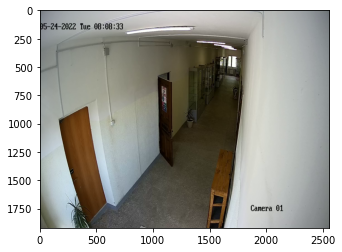

In [14]:
ret, frame = vs.read()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
# video1
h, w, c = frame.shape
h, w, c

(1920, 2560, 3)

In [16]:
# video2
h, w, c = frame.shape
h, w, c

(1920, 2560, 3)

In [17]:
frame = cv2.resize(frame, (1920,1080))

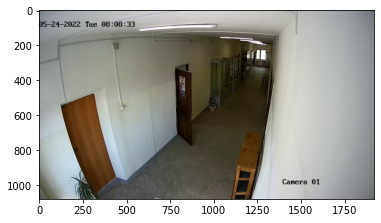

In [18]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
# Словарь с координатами нижних точек дверей
door_dict = {'1': np.array((1000, 350)),
            '2': np.array((660, 840)),
            '3': np.array((380, 1140)),
            '4': np.array((320, 1228)),
            '5': np.array((310, 1310)),
            '6': np.array((350, 1310)),
            '7': np.array((390, 1300)),
            '8': np.array((460, 1300)),
            '9': np.array((680, 1290))}

In [24]:
img = frame[:h//9,:w//3,:]

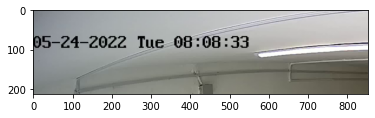

In [25]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
# Model
seek_model = torch.hub.load('ultralytics/yolov5', 'yolov5l6')  # or yolov5n - yolov5x6, custom

Using cache found in /home/andrey/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-31 Python-3.9.2 torch-1.11.0+cu102 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4040MiB)

Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients
Adding AutoShape... 


In [27]:
cls_model = models.resnet18()
cls_model = torch.load('cls_model.pt')
DEVICE = torch.device("cuda")
cls_model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [44]:
def clean_date(d):
    dig = '0123456789-:'; nd = '';
    date = ' '.join(d).replace('Z', '2').replace('z', '2').replace('O', '0')
    # print(date)
    if date.find('-202 ') >= 0: date=date.replace('202','2022');
    # print(date.find('-202 '))
    # print(nd)
    for it in date:
        if it in dig: nd += it;
    # print(nd)
    nd = '2022 '.join(nd.split('2022'))
    if len(nd) < 18: return '0';
    # print(nd)
    ddd = nd.split(' ')[0].split('-')
    if len(ddd) != 3: return '0';
    res = ddd[2]+'-'+ddd[0][-2:]+'-'+ddd[1]+' '+nd.split(' ')[1]
    return res

In [30]:
def get_class(im):
    im = Image.fromarray(im)
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    im = np.array(im.resize((224, 224)))
    im = np.array(im / 255, dtype='float32')
    im = normalize(im)
    cls_model.eval()
    pred = cls_model(im.unsqueeze(0).to(DEVICE)).cpu()
    probs = torch.nn.functional.softmax(pred.detach(), dim=-1).numpy()
    y_pred = label_encoder.classes_[np.argmax(probs,-1)][0]
    return y_pred

In [31]:
def get_person(image):
    df = seek_model(image).pandas().xyxy[0]
    if len(df[df['name'] == 'person']) > 0:
        for item in df[df['name'] == 'person'].values:
            xmin = int(item[0])
            xmax = int(item[2])
            ymin = int(item[1])
            ymax = int(item[3])
            x=(xmin+xmax)//2
            coords = (ymax, x)
            cls = get_class(image[ymin:ymax,xmin:xmax,:])
            return coords, cls
    return (0,0), -1

In [32]:
def get_action(crd):
    crd = np.array(crd)
    res = 100000000; act = 0;
    for k in door_dict:
        r = math.dist(door_dict[k], crd)
        if r < res:
            res = r; act = k;
    return act

In [46]:
video = cv2.VideoCapture("test/test.avi")
fps = video.get(cv2.CAP_PROP_FPS)
fr = 0
old_date = ''; imcount = 0;
idx_list = []
action_stack = []
g = open('result.csv', 'a'); g.write('id,employee,action\n'); g.close();
while True:
    idx = []
    ret, frame = video.read()
    if not ret:
        print("end of file")
        break
    fr += 1
    if fr % 15 != 0: continue;
        
    h, w, c = frame.shape
    if h != 1080 and w != 1920:
        frame = cv2.resize(frame, (1920,1080))
    date_img = frame[:h//9,:w//3,:]
    date = reader.readtext(date_img, detail=0)
    # print(date)
    date = clean_date(date)
    if date == '0': continue;
    if old_date != date:
        old_date = date
        # print('new',date)
    
    df = test[test.date == date]
    if len(df) > 0:
        for it in df.values:
            # print('many')
            idx.append(it[0])
            # print(df.id.item())

    image = frame.copy()
    coords, cls = get_person(image)
    # print(coords, cls)
    
    if coords == (0,0):
        act_cls = 0
    else:
        act_cls = get_action(coords)

    # print(cls, act_cls)
    action_stack.append((cls, act_cls))

    if len(idx) > 0:
        print('индекс для записи', idx)
        print('классы', cls, act_cls)
        if len(action_stack) > 4:
            cl_old = 0; cla_old = 0; cla_cnt = 0;
            for cll in range(len(action_stack)-1, -1, -1):
                cl, cla = action_stack[cll]
                if cl == -1:
                    cla_cnt += 1
                    continue
                else:
                    if cla_cnt > 2:
                        cl_old = cl; cla_old = '1'+cla;
                    else:
                        cl_old = cl; cla_old = cla;
                    break;
            
            for ind in idx:
                if ind not in idx_list:
                    g = open('result.csv', 'a'); g.write(f'{ind},{cl_old},{cla_old}\n'); g.close();
                    idx_list.append(ind)

    if len(action_stack) > 30:
        action_stack.pop(0)
        
# g.close()

индекс для записи [135]
классы -1 0
индекс для записи [135]
классы -1 0
индекс для записи [136]
классы 0 4
индекс для записи [136]
классы -1 0
индекс для записи [137]
классы -1 0
индекс для записи [138]
классы -1 0
индекс для записи [138]
классы -1 0
индекс для записи [139]
классы -1 0
индекс для записи [140]
классы -1 0
индекс для записи [141]
классы -1 0
индекс для записи [141]
классы -1 0
индекс для записи [142]
классы -1 0
индекс для записи [143]
классы -1 0
индекс для записи [144]
классы -1 0
индекс для записи [144]
классы -1 0
индекс для записи [145]
классы -1 0
индекс для записи [146]
классы -1 0
индекс для записи [147]
классы -1 0
индекс для записи [147]
классы -1 0
индекс для записи [148]
классы -1 0
индекс для записи [149]
классы -1 0
индекс для записи [149]
классы -1 0
индекс для записи [150]
классы -1 0
индекс для записи [150]
классы -1 0
индекс для записи [151]
классы 0 4
индекс для записи [152]
классы -1 0
индекс для записи [152]
классы -1 0
индекс для записи [153]
классы

индекс для записи [292]
классы 3 2
индекс для записи [293]
классы 3 4
индекс для записи [294]
классы -1 0
индекс для записи [295]
классы 3 6
индекс для записи [295]
классы -1 0
индекс для записи [296]
классы -1 0
индекс для записи [296]
классы 3 6
индекс для записи [297]
классы 0 6
индекс для записи [297]
классы 0 6
индекс для записи [298]
классы 10 4
индекс для записи [299]
классы 5 6
индекс для записи [299]
классы -1 0
индекс для записи [300]
классы -1 0
индекс для записи [300]
классы 2 4
индекс для записи [301]
классы 0 6
индекс для записи [301]
классы -1 0
индекс для записи [302]
классы -1 0
индекс для записи [303]
классы 3 2
индекс для записи [303]
классы 3 2
индекс для записи [304]
классы -1 0
индекс для записи [304]
классы -1 0
индекс для записи [305]
классы 3 7
индекс для записи [305]
классы -1 0
индекс для записи [306]
классы -1 0
индекс для записи [307]
классы -1 0
индекс для записи [307]
классы -1 0
индекс для записи [308]
классы -1 0
индекс для записи [309]
классы 10 7
инде

индекс для записи [438]
классы -1 0
индекс для записи [438]
классы 0 6
индекс для записи [439]
классы 10 3
индекс для записи [440]
классы -1 0
индекс для записи [440]
классы -1 0
индекс для записи [441]
классы 5 7
индекс для записи [441]
классы -1 0
индекс для записи [442]
классы -1 0
индекс для записи [443]
классы 10 9
индекс для записи [443]
классы -1 0
индекс для записи [444]
классы -1 0
индекс для записи [445]
классы 0 7
индекс для записи [446]
классы 0 4
индекс для записи [447]
классы 0 4
индекс для записи [447]
классы -1 0
индекс для записи [448]
классы 5 7
индекс для записи [449]
классы 3 3
индекс для записи [449]
классы -1 0
индекс для записи [450]
классы -1 0
индекс для записи [450]
классы 10 3
индекс для записи [451]
классы 10 7
индекс для записи [451]
классы -1 0
индекс для записи [452]
классы 0 7
индекс для записи [453]
классы 0 4
индекс для записи [453]
классы 0 4
индекс для записи [454]
классы 5 7
индекс для записи [455]
классы -1 0
индекс для записи [455]
классы -1 0
инд

индекс для записи [581]
классы -1 0
индекс для записи [581]
классы -1 0
индекс для записи [583]
классы -1 0
индекс для записи [583]
классы -1 0
индекс для записи [584]
классы -1 0
индекс для записи [584]
классы -1 0
индекс для записи [585]
классы 10 2
индекс для записи [585]
классы -1 0
индекс для записи [586]
классы -1 0
индекс для записи [587]
классы -1 0
индекс для записи [587]
классы 0 6
индекс для записи [588]
классы 0 6
индекс для записи [589]
классы 0 4
индекс для записи [589]
классы -1 0
индекс для записи [590]
классы -1 0
индекс для записи [590]
классы 3 2
индекс для записи [591]
классы -1 0
индекс для записи [592]
классы -1 0
индекс для записи [592]
классы 5 6
индекс для записи [593]
классы 0 4
индекс для записи [593]
классы -1 0
индекс для записи [594]
классы 0 4
индекс для записи [594]
классы 5 4
индекс для записи [595]
классы -1 0
индекс для записи [595]
классы -1 0
индекс для записи [596]
классы -1 0
индекс для записи [596]
классы -1 0
индекс для записи [597]
классы 4 6
и

индекс для записи [725]
классы -1 0
индекс для записи [725]
классы -1 0
индекс для записи [726]
классы -1 0
индекс для записи [726]
классы -1 0
индекс для записи [727]
классы 10 2
индекс для записи [727]
классы 0 2
индекс для записи [728]
классы -1 0
индекс для записи [729]
классы 3 2
индекс для записи [730]
классы 0 2
индекс для записи [730]
классы 4 2
индекс для записи [731]
классы 0 3
индекс для записи [732]
классы -1 0
индекс для записи [732]
классы 3 7
индекс для записи [733]
классы -1 0
индекс для записи [733]
классы -1 0
индекс для записи [734]
классы -1 0
индекс для записи [734]
классы -1 0
индекс для записи [735]
классы 0 6
индекс для записи [736]
классы -1 0
индекс для записи [737]
классы -1 0
индекс для записи [737]
классы -1 0
индекс для записи [738]
классы -1 0
индекс для записи [739]
классы 5 2
индекс для записи [739]
классы -1 0
индекс для записи [740]
классы -1 0
индекс для записи [741]
классы -1 0
индекс для записи [741]
классы -1 0
индекс для записи [742]
классы -1 0


индекс для записи [872]
классы 0 5
индекс для записи [872]
классы 0 5
индекс для записи [873]
классы 10 4
индекс для записи [874]
классы -1 0
индекс для записи [874]
классы -1 0
индекс для записи [875]
классы 0 6
индекс для записи [875]
классы -1 0
индекс для записи [876]
классы 0 4
индекс для записи [877]
классы 0 6
индекс для записи [877]
классы -1 0
индекс для записи [878]
классы -1 0
индекс для записи [878]
классы 0 6
индекс для записи [879]
классы -1 0
индекс для записи [880]
классы 0 4
индекс для записи [881]
классы 0 4
индекс для записи [881]
классы 0 6
индекс для записи [882]
классы -1 0
индекс для записи [882]
классы 0 6
индекс для записи [883]
классы 3 2
индекс для записи [884]
классы 3 2
индекс для записи [885]
классы 3 6
индекс для записи [885]
классы 0 6
индекс для записи [886]
классы -1 0
индекс для записи [887]
классы -1 0
индекс для записи [888]
классы -1 0
индекс для записи [889]
классы -1 0
индекс для записи [889]
классы -1 0
индекс для записи [890]
классы -1 0
индекс

индекс для записи [1022]
классы -1 0
индекс для записи [1022]
классы 5 6
индекс для записи [1023]
классы -1 0
индекс для записи [1024]
классы -1 0
индекс для записи [1024]
классы -1 0
индекс для записи [1025]
классы -1 0
индекс для записи [1025]
классы -1 0
индекс для записи [1026]
классы -1 0
индекс для записи [1026]
классы -1 0
индекс для записи [1027]
классы -1 0
индекс для записи [1028]
классы 3 2
индекс для записи [1028]
классы 3 2
индекс для записи [1029]
классы -1 0
индекс для записи [1030]
классы -1 0
индекс для записи [1030]
классы 3 6
индекс для записи [1031]
классы 10 2
индекс для записи [1031]
классы -1 0
индекс для записи [1032]
классы -1 0
индекс для записи [1033]
классы -1 0
индекс для записи [1034]
классы 5 4
индекс для записи [1035]
классы -1 0
индекс для записи [1036]
классы 10 2
индекс для записи [1036]
классы 10 2
индекс для записи [1037]
классы -1 0
индекс для записи [1037]
классы -1 0
индекс для записи [1038]
классы -1 0
индекс для записи [1038]
классы -1 0
индекс

индекс для записи [1163]
классы -1 0
индекс для записи [1163]
классы -1 0
индекс для записи [1164]
классы -1 0
индекс для записи [1164]
классы -1 0
индекс для записи [1165]
классы 0 4
индекс для записи [1165]
классы -1 0
индекс для записи [1166]
классы 10 2
индекс для записи [1167]
классы 10 2
индекс для записи [1167]
классы -1 0
индекс для записи [1168]
классы -1 0
индекс для записи [1169]
классы -1 0
индекс для записи [1169]
классы -1 0
индекс для записи [1170]
классы -1 0
индекс для записи [1170]
классы -1 0
индекс для записи [1171]
классы -1 0
индекс для записи [1171]
классы -1 0
индекс для записи [1172]
классы -1 0
индекс для записи [1173]
классы -1 0
индекс для записи [1173]
классы -1 0
индекс для записи [1174]
классы -1 0
индекс для записи [1174]
классы 11 3
индекс для записи [1175]
классы -1 0
индекс для записи [1175]
классы -1 0
индекс для записи [1176]
классы -1 0
индекс для записи [1177]
классы -1 0
индекс для записи [1177]
классы -1 0
индекс для записи [1178]
классы -1 0
ин

In [47]:
test

,id,date
0,135,2022-05-22 11:51:06
1,136,2022-05-22 11:51:25
2,137,2022-05-22 12:04:27
3,138,2022-05-22 12:07:56
4,139,2022-05-22 12:08:10
...,...,...
1116,1251,2022-05-24 07:57:00
1117,1252,2022-05-24 07:57:32
1118,1253,2022-05-24 07:57:34
1119,1254,2022-05-24 07:57:39


In [48]:
myres_d = pd.read_csv('result.csv')
myres_d

,id,employee,action
0,135,0,0
1,136,0,4
2,137,3,13
3,138,3,13
4,139,5,14
...,...,...,...
1085,1251,0,6
1086,1252,0,16
1087,1253,0,16
1088,1254,0,16


In [49]:
myres = pd.read_csv('result.csv', index_col='id')
myres

,employee,action
id,,
135,0,0
136,0,4
137,3,13
138,3,13
139,5,14
...,...,...
1251,0,6
1252,0,16
1253,0,16


In [50]:
for idx in list(set(test.id) - set(myres_d.id)):
    myres.loc[idx] = {'employee':0,'action':0}

In [54]:
mrs = myres.copy()

In [58]:
mrs.sort_index().to_csv('result2.csv')

In [248]:
myres.index = myres.id
myres

,id,employee,action
id,,,
135,135,0,0
136,136,2,14
137,137,0,13
138,138,0,0
139,139,2,4
...,...,...,...
243,243,0,0
244,244,0,0
886,886,0,0


In [249]:
myres.drop(['id'], axis=1, inplace=True)
myres

,employee,action
id,,
135,0,0
136,2,14
137,0,13
138,0,0
139,2,4
...,...,...
243,0,0
244,0,0
886,0,0


In [262]:
myres.action.unique()

array([ 0,  4, 13, 14,  9, 19,  5,  3,  8,  2, 12,  6, 16,  7, 17,  1, 11, 18, 15])

In [263]:
myres.employee.unique()

array([ 0,  5, 10,  2,  8,  3,  6, 11])

In [264]:
myres.to_csv('result2.csv')